In [1]:

pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from transformers import DistilBertTokenizer, DistilBertModel, RobertaTokenizerFast, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
from sklearn.svm import LinearSVC

In [3]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
import re
songs={}
artists=["Rihanna",
    "TaylorSwift","Beyonce","ArianaGrande"]

def read_file(artist):
    df=pd.read_csv(artist+".csv")
    df = pd.DataFrame({
    "lyrics": df['lyrics'].apply(lambda text: re.sub(r'\s*\n\s*', '. ', text)),
    "artist": artist  
    })
    return df

for artist in artists:
    songs[artist]=read_file(artist)

df = pd.concat(songs.values(), ignore_index=True)
df['tokens'] = df['lyrics'].apply(lambda x: x.split())
df.head()


,lyrics,artist,tokens
0,"Come, Mr. DJ, song pon de replay. Come, Mr. DJ...",Rihanna,"[Come,, Mr., DJ,, song, pon, de, replay., Come..."
1,Na-na-na-na-na. Na-na-na-na-na. Na-na-na-na-na...,Rihanna,"[Na-na-na-na-na., Na-na-na-na-na., Na-na-na-na..."
2,I wanna let you know. That you don't have to g...,Rihanna,"[I, wanna, let, you, know., That, you, don't, ..."
3,"Vybz Kartel. Rihanna. You know, my love for yo...",Rihanna,"[Vybz, Kartel., Rihanna., You, know,, my, love..."
4,"Here we go. (Oh) la, la, la, la, la, yeah. (Oh...",Rihanna,"[Here, we, go., (Oh), la,, la,, la,, la,, la,,..."


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

class LyricsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512, stride=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.stride = stride

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Tokenize without truncation first, to allow chunking
        tokens = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=False,
            add_special_tokens=True
        )["input_ids"].squeeze(0)

        # Break into chunks
        chunks = []
        for start in range(0, tokens.size(0), self.stride):
            end = start + self.max_length
            chunk_ids = tokens[start:end]
            if chunk_ids.size(0) < 5: 
                break
            chunks.append(chunk_ids)

        return chunks

def collate_fn(batch):
    # batch is a list of chunk lists
    all_input_ids, all_attention_masks, offsets = [], [], []
    for chunks in batch:
        offsets.append(len(all_input_ids))
        for chunk in chunks:
            all_input_ids.append(chunk)
    # pad them
    enc = tokenizer.pad(
        {"input_ids": all_input_ids},
        padding="longest",
        return_tensors="pt"
    )
    return enc["input_ids"], enc["attention_mask"], offsets

def get_bert_embeddings(texts,
                        tokenizer,
                        model,
                        max_length=512,
                        batch_size=8,
                        device=None,
                        pool: str = "cls"):
    """
    Tokenizes+truncates each full lyric to 512 tokens, pads the batch, then
    runs it through the model in batches for speed.
    """
    import torch
    from torch.utils.data import DataLoader, TensorDataset
    from tqdm.auto import tqdm

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # 1) Tokenize all texts at once with truncation+padding
    enc = tokenizer(
        texts,
        padding="longest",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    ds = TensorDataset(enc["input_ids"], enc["attention_mask"])
    dl = DataLoader(ds, batch_size=batch_size)

    all_embs = []
    with torch.no_grad():
        for input_ids, attn_mask in tqdm(dl, desc="Embedding"):
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            out = model(input_ids=input_ids, attention_mask=attn_mask)
            last_hidden = out.last_hidden_state  # (B, T, H)

            if pool == "cls":
                emb = last_hidden[:, 0, :].cpu().numpy()     # take [CLS]
            else:
                mask = attn_mask.unsqueeze(-1)
                summed = (last_hidden * mask).sum(1)
                counts = mask.sum(1).clamp(min=1)
                emb = (summed / counts).cpu().numpy()

            all_embs.append(emb)

    return np.vstack(all_embs)


In [27]:
# 1. Instantiate tokenizer & model once
from transformers import RobertaTokenizerFast, RobertaModel

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
model     = RobertaModel.from_pretrained("roberta-base")
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['artist'])
X,y=df['lyrics'],df['encoded_label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, stratify=y,test_size=0.2, random_state=0
)

# 2. Encode train/test
X_train_vec = get_bert_embeddings(
    X_train_text.tolist(),
    tokenizer,
    model      
)
X_test_vec  = get_bert_embeddings(
    X_test_text.tolist(),
    tokenizer,
    model
)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Embedding: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Logistic Regression Evaluation
Accuracy: 0.838
Classification Report:
               precision    recall  f1-score   support

ArianaGrande       0.74      0.70      0.72        20
     Beyonce       0.76      0.68      0.72        19
     Rihanna       0.92      1.00      0.96        23
 TaylorSwift       0.87      0.89      0.88        37

    accuracy                           0.84        99
   macro avg       0.82      0.82      0.82        99
weighted avg       0.83      0.84      0.84        99



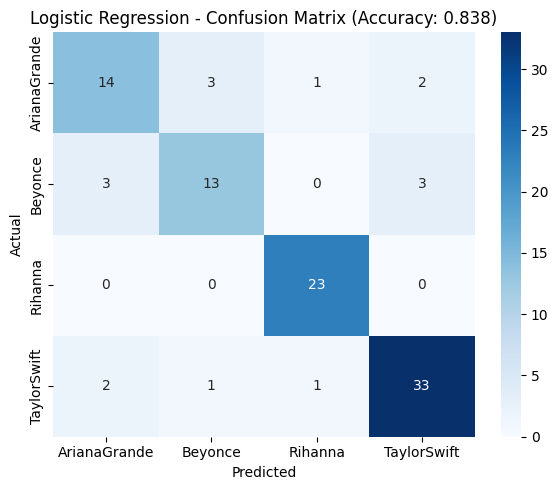

SVM Evaluation
Accuracy: 0.879
Classification Report:
               precision    recall  f1-score   support

ArianaGrande       0.78      0.70      0.74        20
     Beyonce       0.79      0.79      0.79        19
     Rihanna       1.00      1.00      1.00        23
 TaylorSwift       0.90      0.95      0.92        37

    accuracy                           0.88        99
   macro avg       0.87      0.86      0.86        99
weighted avg       0.88      0.88      0.88        99



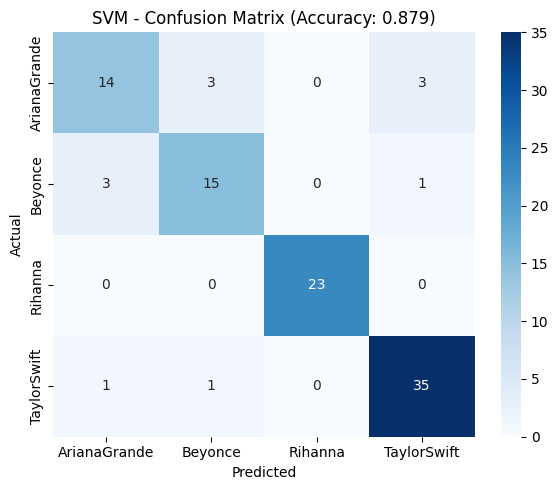

LinearSVM Evaluation
Accuracy: 0.879
Classification Report:
               precision    recall  f1-score   support

ArianaGrande       0.79      0.75      0.77        20
     Beyonce       0.74      0.74      0.74        19
     Rihanna       0.96      1.00      0.98        23
 TaylorSwift       0.95      0.95      0.95        37

    accuracy                           0.88        99
   macro avg       0.86      0.86      0.86        99
weighted avg       0.88      0.88      0.88        99



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


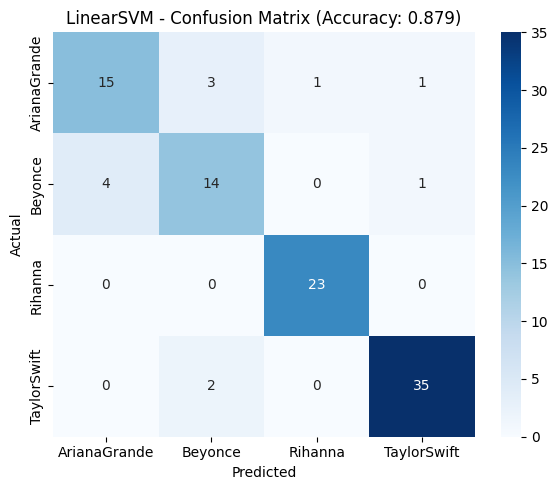

Random Forest Evaluation
Accuracy: 0.818
Classification Report:
               precision    recall  f1-score   support

ArianaGrande       0.72      0.65      0.68        20
     Beyonce       0.80      0.63      0.71        19
     Rihanna       0.96      1.00      0.98        23
 TaylorSwift       0.79      0.89      0.84        37

    accuracy                           0.82        99
   macro avg       0.82      0.79      0.80        99
weighted avg       0.82      0.82      0.81        99



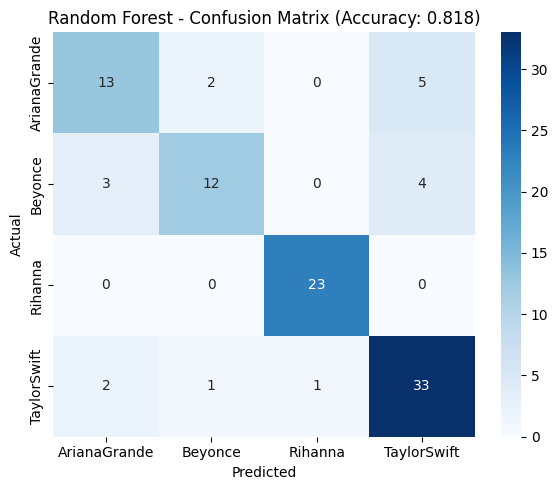

Naive Bayes Evaluation
Accuracy: 0.788
Classification Report:
               precision    recall  f1-score   support

ArianaGrande       0.67      0.70      0.68        20
     Beyonce       0.63      0.63      0.63        19
     Rihanna       0.92      1.00      0.96        23
 TaylorSwift       0.85      0.78      0.82        37

    accuracy                           0.79        99
   macro avg       0.77      0.78      0.77        99
weighted avg       0.79      0.79      0.79        99



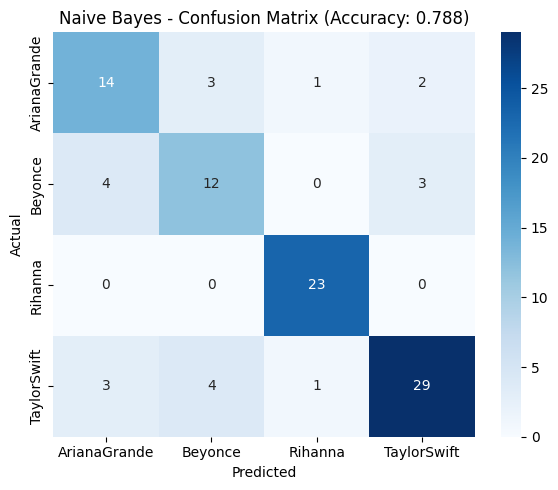

In [29]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "LinearSVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB()
}



for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Evaluation")
    print("Accuracy:", round(acc, 3))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Matplotlib + Seaborn confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix (Accuracy: {acc:.3f})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

### Fine Tuning

In [7]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import DistilBertTokenizerFast
from transformers import TrainingArguments

In [8]:
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

In [9]:
songs={}
artists=["Rihanna",
    "TaylorSwift","Beyonce","ArianaGrande"]

def read_file(artist):
    df=pd.read_csv(artist+".csv")
    df = pd.DataFrame({
    "lyrics": df['lyrics'].apply(lambda text: re.sub(r'\s*\n\s*', '. ', text)),
    "artist": artist  
    })
    return df

for artist in artists:
    songs[artist]=read_file(artist)

fine_df = pd.concat(songs.values(), ignore_index=True)
fine_df.head()


,lyrics,artist
0,"Come, Mr. DJ, song pon de replay. Come, Mr. DJ...",Rihanna
1,Na-na-na-na-na. Na-na-na-na-na. Na-na-na-na-na...,Rihanna
2,I wanna let you know. That you don't have to g...,Rihanna
3,"Vybz Kartel. Rihanna. You know, my love for yo...",Rihanna
4,"Here we go. (Oh) la, la, la, la, la, yeah. (Oh...",Rihanna


Map: 100%|██████████| 99/99 [00:00<00:00, 2198.59 examples/s]
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
1,1.280700,1.113635,0.636364,0.552703,0.599680
2,0.744900,0.691822,0.717172,0.642390,0.675055
3,0.586800,0.516173,0.848485,0.830528,0.849878
4,0.489700,0.472790,0.818182,0.787349,0.812407



Classification Report:

              precision    recall  f1-score   support

ArianaGrande       0.67      0.80      0.73        20
     Beyonce       0.76      0.68      0.72        19
     Rihanna       0.92      1.00      0.96        23
 TaylorSwift       0.97      0.86      0.91        37

    accuracy                           0.85        99
   macro avg       0.83      0.84      0.83        99
weighted avg       0.86      0.85      0.85        99



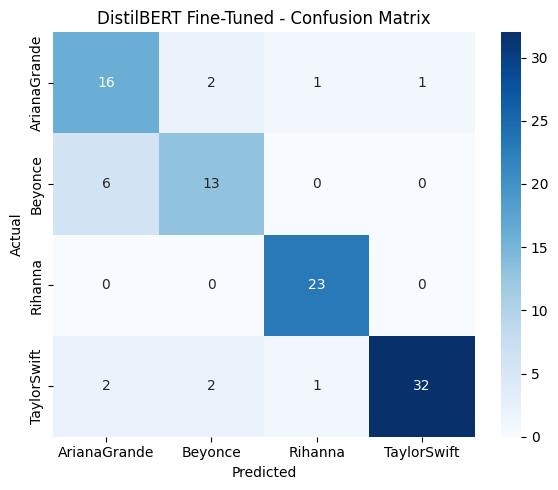

In [21]:
from transformers import EarlyStoppingCallback
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch['lyrics'], padding="max_length", truncation=True, max_length=512)

fine_df['label_encoded'] = LabelEncoder().fit_transform(fine_df['artist'])
train_df, test_df = train_test_split(
    fine_df[['lyrics','label_encoded']],
    stratify=fine_df['label_encoded'], 
    test_size=0.2, 
    random_state=0
)
train_dataset = Dataset.from_pandas(train_df.rename(columns={'label_encoded': 'labels'}))
test_dataset = Dataset.from_pandas(test_df.rename(columns={'label_encoded': 'labels'}))

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Step 5: Load DistilBERT model for classification
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Step 6: Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=10,
    eval_steps=10,
    warmup_ratio=0.1,
    seed=42,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy"
)

# Accuracy metric for Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "weighted_f1": f1_score(labels, preds, average="weighted"),
    }

# Step 7: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Step 8: Fine-tune!
trainer.train()

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=LabelEncoder().fit(fine_df['artist']).classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LabelEncoder().fit(fine_df['artist']).classes_, yticklabels=LabelEncoder().fit(fine_df['artist']).classes_)
plt.title("DistilBERT Fine-Tuned - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()